In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from timm.bits import initialize_device
from timm.data import create_loader_v2, AugCfg, MixupCfg, PreprocessCfg
from timm.data.auto_augment import rand_augment_transform
from timm.data.dataset_factory import create_dataset
from timm.data.mixup import Mixup
from timm.data.random_erasing import RandomErasing
from torchvision.transforms import functional as F

from src.notebooks_utils import show_grid

In [4]:
torch.manual_seed(42);

In [5]:
plt.rcParams["savefig.bbox"] = 'tight'
output_dir = Path("outputs") / "data_augmentations"

In [6]:
dev_env = initialize_device()

DeviceEnvCuda(device=device(type='cuda'), world_size=1, local_rank=0, global_rank=0, amp=False, autocast=<class 'contextlib.suppress'>, memory_format=None, dtype=None)


In [7]:
dataset_name = "tfds/imagenet2012"
data_dir = "gs://large-ds/tensorflow_datasets/"
ds = create_dataset(dataset_name,
                    root=data_dir,
                    split="train",
                    is_training=True,
                    batch_size=2)

MEAN = (0., 0., 0.)
STD = (1., 1., 1.)
prepr_cfg = PreprocessCfg(input_size=(3, 224, 224),
                          mean=MEAN, 
                          std=STD,
                          interpolation='bilinear',
                          crop_pct=0.875,
                          aug=None)

## MixUp

In [8]:
mixup_cfg = MixupCfg(prob=1.0,
                     switch_prob=0.5,
                     mode="batch",
                     mixup_alpha=0.9,
                     label_smoothing=0.0,
                     num_classes=1000)
dl = create_loader_v2(ds,
                      batch_size=2, 
                      is_training=True,
                      mix_cfg=mixup_cfg,
                      pp_cfg=prepr_cfg)

2022-03-30 23:43:34.645182: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


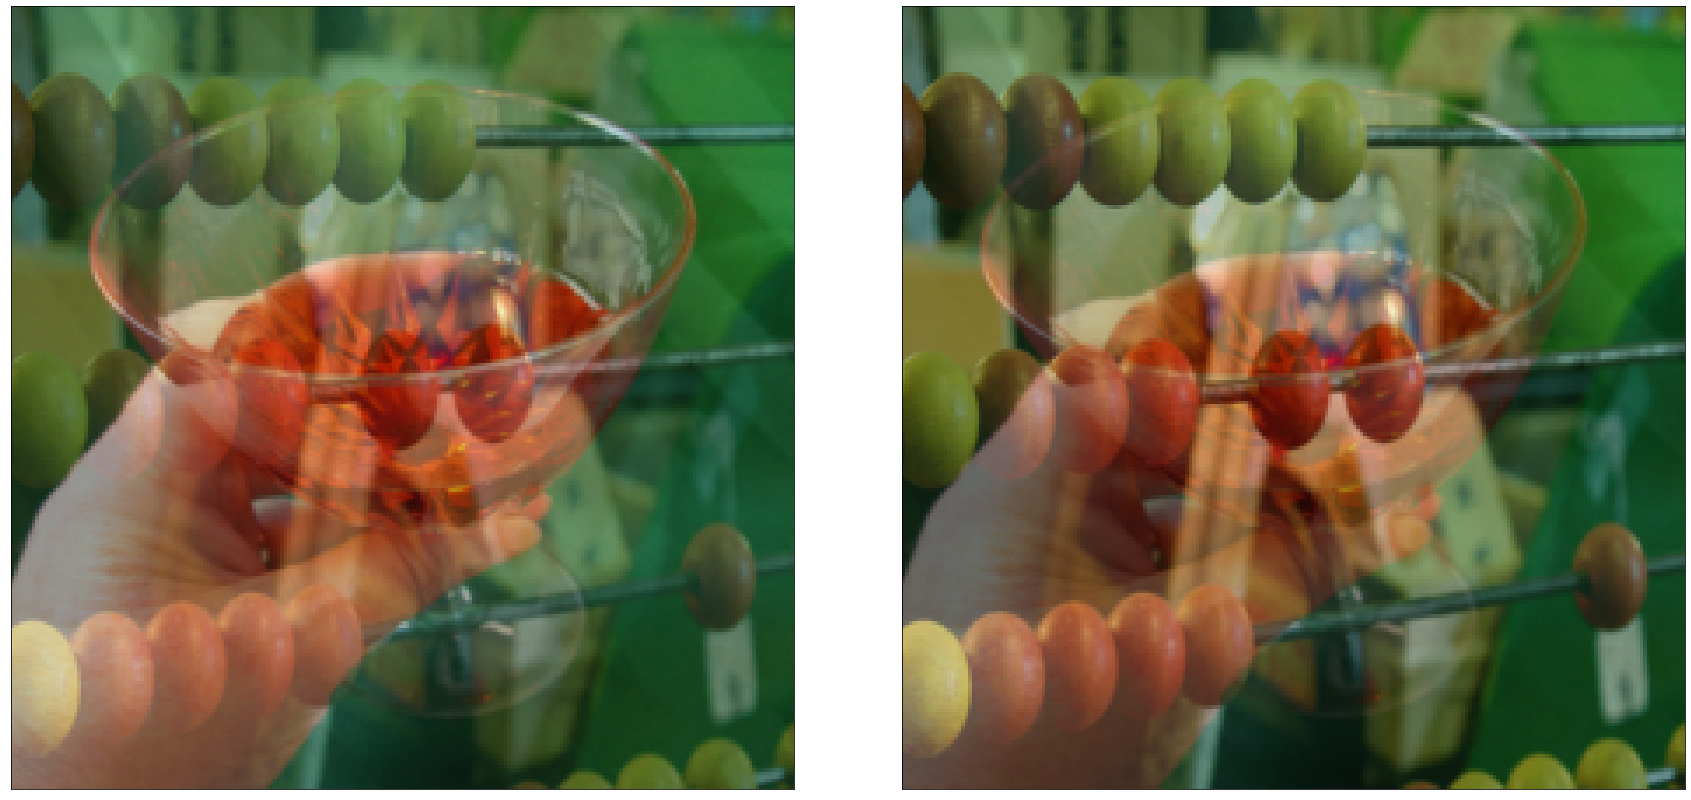

In [9]:
xs, ys = next(iter(dl))
show_grid(xs, ncols=2, filename=output_dir / "mixup.jpg")

## CutMix

In [10]:
mixup_cfg = MixupCfg(prob=1.0,
                     switch_prob=0.5,
                     mode="batch",
                     mixup_alpha=0.0,
                     cutmix_alpha=1.0,
                     label_smoothing=0.0,
                     num_classes=1000)
dl = create_loader_v2(ds,
                      batch_size=2, 
                      is_training=True,
                      mix_cfg=mixup_cfg,
                      pp_cfg=prepr_cfg)

2022-03-30 23:43:43.303303: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


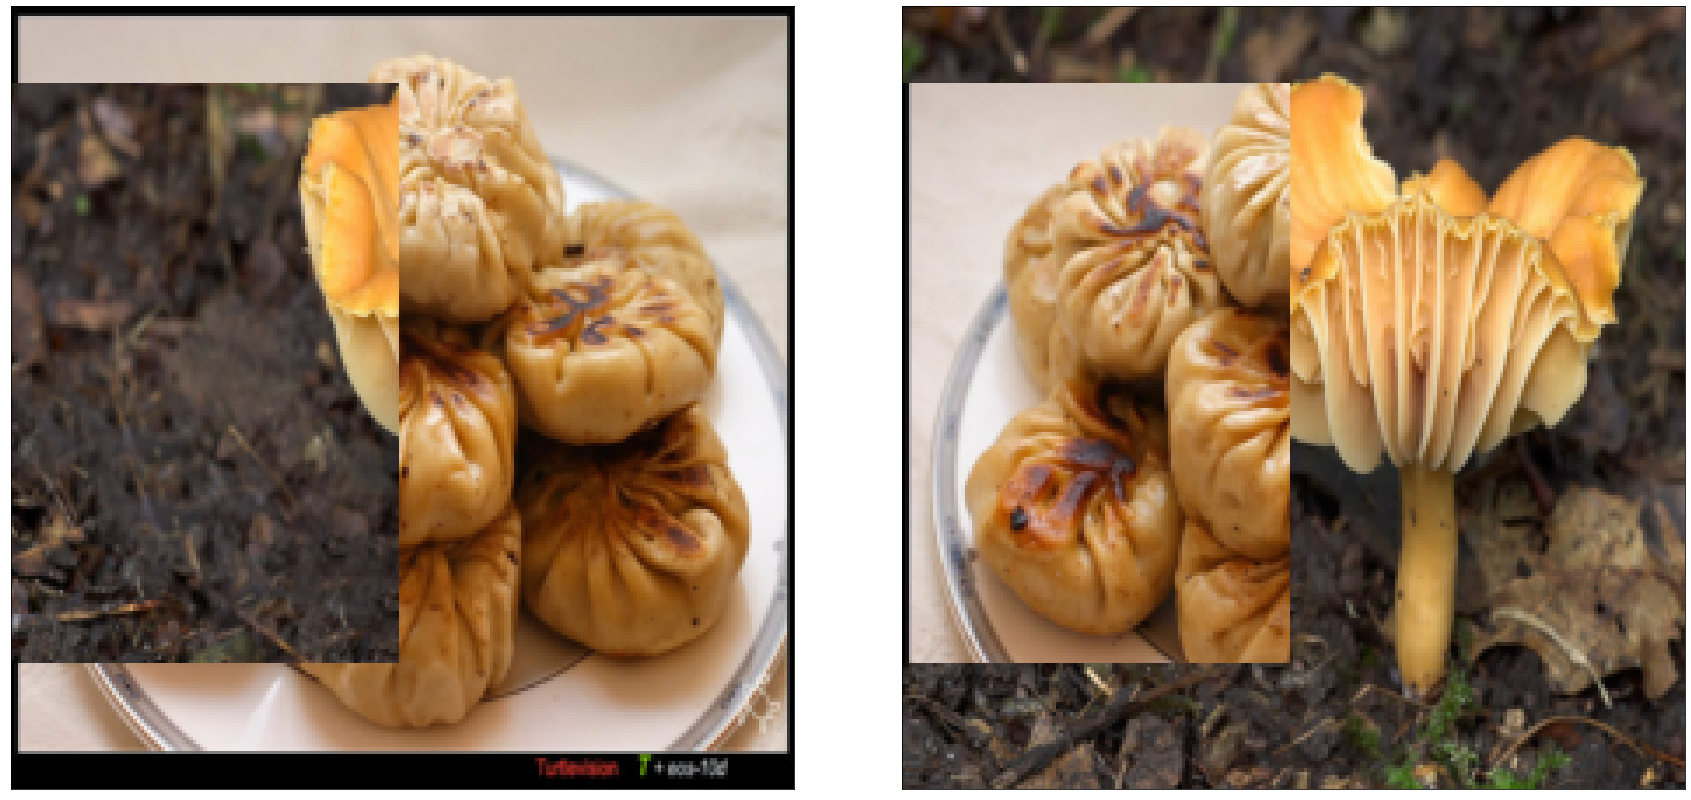

In [11]:
xs, ys = next(iter(dl))
show_grid(xs, ncols=2, filename=output_dir / "cutmix.jpg")

## RandAugment

In [12]:
dl = create_loader_v2(ds,
                      batch_size=1, 
                      is_training=True,
                      pp_cfg=prepr_cfg)

ra_params = dict(translate_const=int(224 * 0.45),
                 img_mean=tuple([min(255, round(255 * x)) for x in MEAN]))

ra_transform = rand_augment_transform("rand-m9-mstd0.5-inc1", ra_params)

In [13]:
xs, ys = next(iter(dl))
xs, ys = xs[0], ys[0]

2022-03-30 23:43:52.491609: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


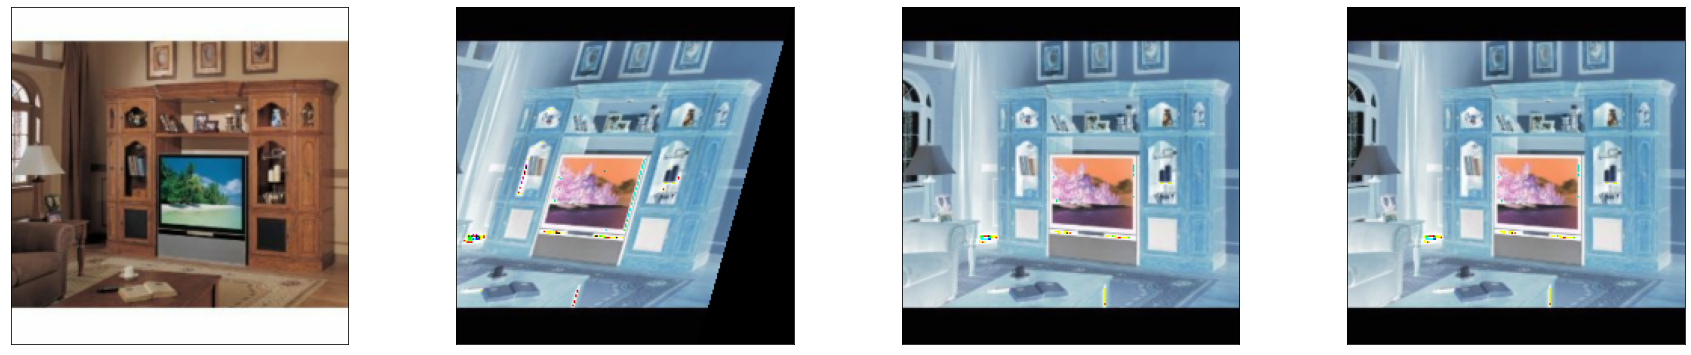

In [14]:
xs_1 = F.pil_to_tensor(ra_transform(F.to_pil_image(xs))).unsqueeze(0)
xs_2 = F.pil_to_tensor(ra_transform(F.to_pil_image(xs))).unsqueeze(0)
xs_3 = F.pil_to_tensor(ra_transform(F.to_pil_image(xs))).unsqueeze(0)

show_grid(torch.cat([xs.unsqueeze(0).cpu(), xs_1, xs_2, xs_3]),
          ncols=4,
          filename=output_dir / "randaugment.jpg")

## Random Erasing

In [15]:
random_erasing = RandomErasing(1.0, mode="pixel", count=1, max_area=1/3)

In [16]:
xs, ys = next(iter(dl))

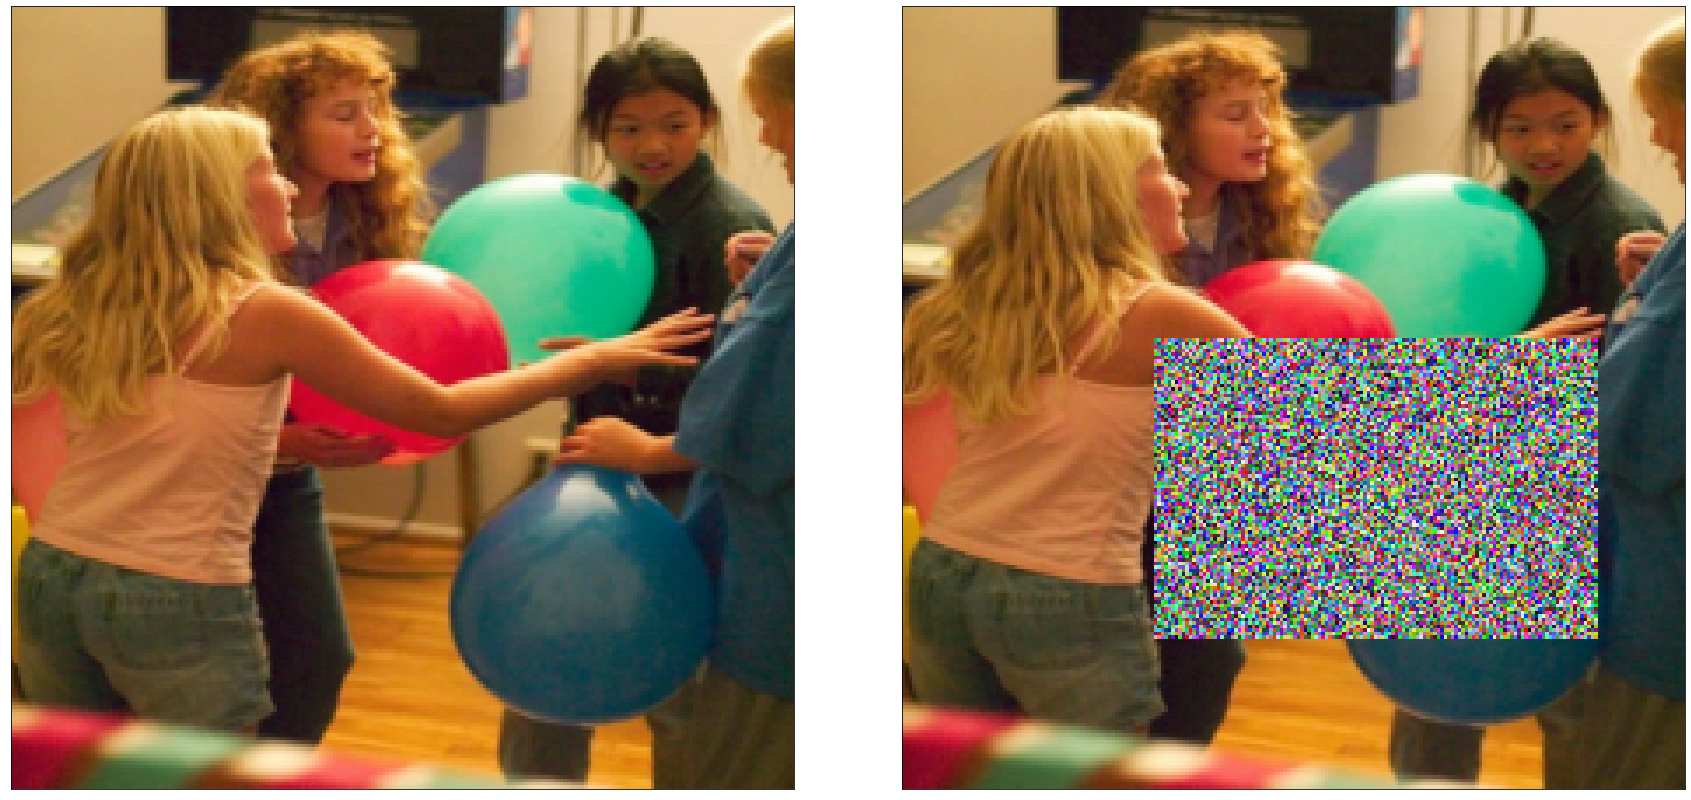

In [17]:
show_grid(torch.cat([xs, random_erasing(xs.clone())]),
          ncols=2,
          filename=output_dir / "random_erasing.jpg")